# Data Imputation

The purpose of this notebook is to create design matrices by exploring different thresholds of missingness and executing different strategies for categorical and quantitative imputation.

In [9]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ADNI_utilities as utils

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import RBF
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR


### Stacking libraries require mlxtend
from mlxtend.classifier import StackingCVClassifier
from mlxtend.regressor import StackingCVRegressor

*This notebook uses [StackingCVClassifer][] and [StackingCVRegressor][] from the `mlxtend` library. Use the following commands to install `mlxtend` and to update other libs to required (latest) versions.*


`conda config --add channels conda-forge`<br>
`conda install -y mlxtend`<br>
`conda update -y pandas`<br>
`conda update -y numpy`<br>
`conda update -y scikit-learn --no-channel-priority`<br>


[StackingCVClassifer]: http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/
[StackingCVRegressor]: http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

## Missing Data

At this point, we have cleaned the data by removing duplicate/highly correlated or informationless features. We also have filled in missing values that could be found elsewhere within the collected study data. To deal with the remaining missingness, we will impute values. First we will define the necessary functions to do the following:
* Drop columns due to missingness threshold
* Combine ADNI Merged data with the cleaned and curated per-patient data
* Normalize the data
* Define the classifiers/regressors along with the ranges of parameters to be tuned
* Identify categorical and quantitative features with missing values
* Iterate over missing features, fit, predict, update, repeat
* Save the intermediate and final results of imputataion


Our goal is to strike a balance between keeping as much data as possible and reducing noise introduced by imputing columns that are nearly completely void of information. We will explore the relationship between these by imputing with different thresholds for missing data. The function below takes a threshold argument for missing values and drops any features from the dataset that exceed that threshold.

In [13]:
def drop_missing_cols(data, threshold):
    """Drops cols from data that have missing values above the threshold.
    
    # Arguments:
        data: The data to drop missing cols from
        threshold: float 0:1, the max allowable percentage of missing values
        
    # Returns
        The data with missing cols dropped.
    """
    cols = data.columns.values

    # Drop columns that don't have at least 1 - threshold non-NA values
    data = data.dropna(axis='columns', thresh=np.floor(data.shape[0] * (1 - threshold)))

    print(f'Dropped columns due to missingness at threshold {threshold}:\n', set(cols) ^ set(data.columns.values))
    return data

We will perform imputation on datasets with different thresholds and compare the results. We also need to set the correct `dtype` for categorical features. Depending on the study phase, some categorical features use text values like `AD`, `MCI`, `MALE`, `FEMALE`, etc., and some use numerical codes. The per-patient data have been cleaned and standardized to use numeric values. We will read in a file that identifies the correct dtypes per column.

Also, we have decided to normalize the data before imputing the missing values. We reason that imputing on the data before normalization may cover up or dilute any bias present in the data. The function below prepares the dataset by merging ADNI Merged and per-patient data, drops columns that exceed the missingness threshold, normalizes the data, and generates lists of categorical and quantitative features that will be required in the imputation process.

In [14]:
def get_combined_data(missing_thresh):
    """Gets the raw combined (ADNI_Merge and Per_Patient) datasets. The
    categorical features will have a dtype of 'int'. 
    
    # Returns:
        Returns the combined (ADNI_Merge and Per_Patient) datasets and lists
        of the categorical and non-categorical features.
    """
    # Read in the combined (Merged and Per Patient) dataset
    pat_comb = pd.read_csv('../data/Per_Patient/pat_merge_b4_impute.csv', index_col='RID')
    
    # Drop cols based on missing threshold
    pat_comb = drop_missing_cols(pat_comb, missing_thresh)

    # Import the dtypes. Categorical variables are represented as int64 as opposed to floats.
    dtypes = pd.read_csv('../data/Per_Patient/patient_firstidx_dtypes.csv', index_col='feature_name')

    # Categoricals from baseline
    categoricals = ['PTETHCAT', 'PTGENDER', 'PTRACCAT', 'PTMARRY', 'FSVERSION', 'APOE4', 'DX_bl']
    for cat in categoricals:
        if cat not in pat_comb.columns:
            categoricals.pop(categoricals.index(cat))

    # Collect categorical columns from pat_data based on dtype=int64
    for i in dtypes.index:
        # RID is the index so skip it
        if i == 'RID':
            continue
        # If dtype is int, the it's categorical
        if 'int' in dtypes.loc[i].data_type and i in pat_comb.columns:
            categoricals.append(i)

    # Remove any dupes
    categoricals = list(set(categoricals))
    non_cat = list(set(pat_comb.columns) ^ set(categoricals))
    return pat_comb, categoricals, non_cat

## Stacking - Meta Ensemble Method

Next we'll use a combination of stacking and grid search to see the effects of missingness and different models on imputation and predictive models. We'll start by defining the classifiers and regressors that we want to evaluate for imputing the missing data. Missing categorical values will be imputed first. During the model based imputation, we'll temporarily fill in missing values from quantitative features using mean based imputation.

Because we have so much missing data in our combined dataset, we decided to use the stacking ensemble method for imputation to try to get the most accurate predictions possible during imputation. In stacking, the predictions of each base estimator are used as features for the *meta-estimator*. This allows the meta-estimator to appropriately weight the base models based on where they perform well or poorly. By selecting different classifiers/regressors and different parameters, we reason that we may get better predictions than any single model may provide independently. 

The function below creates a `StackingCVClassifier` that uses `SVC`, `KNN`, and `AdaBoostClassifier` with a `DecisionTreeClassifier` base estimator as the classifiers. The `SCV` classifier is wrapped in a `BaggingClassifier` which is itself wrapped in a `OneVsRestClassifier`. `LogisticRegression` was selected as the *meta-classifier*. This function returns the `StackingCVClassifer` along with a parameter grid for the base classifiers. These will later be wrapped in a `GridSearchCV` object to do cross validation using the different values of each estimator's tuning parameters.

In [15]:
def make_clf_stack():
    """Convenience function to create a stacking meta classifier.
    
    # Returns:
        A Stacking CV Classifier and a parameter grid.
    """
    # Define classification estimators and their param grids
    cl_params = {}

    # SVC
    svc = SVC(gamma='scale', decision_function_shape='ovr', probability=True, class_weight='balanced')
    bclf = BaggingClassifier(svc, max_samples=.5, max_features=.5, n_estimators=10, n_jobs=-1)
    clf1 = OneVsRestClassifier(bclf, n_jobs=-1)
    cl_params['onevsrestclassifier__estimator__base_estimator__kernel'] = ['linear', 'rbf']
    cl_params['onevsrestclassifier__estimator__base_estimator__C'] = 10. ** np.arange(-2, 2)

    # AdaBoost with DecisionTree classifier
    dtc = DecisionTreeClassifier(max_features="auto", class_weight="balanced", max_depth=None)
    clf2 = AdaBoostClassifier(base_estimator=dtc)
    cl_params['adaboostclassifier__base_estimator__criterion'] = ["gini"]
    cl_params['adaboostclassifier__n_estimators'] = [100]

    # KNN
    clf3 = KNeighborsClassifier(n_jobs=-1)
    cl_params['kneighborsclassifier__n_neighbors'] = [2, 5, 10, 100]

    # Meta-classifier
    meta_clf = LogisticRegression(solver='lbfgs', n_jobs=-1, multi_class='auto')

    # Stacking-Classifier
    sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                                meta_classifier=meta_clf)
    
    return sclf, cl_params

We take a similar approach to impute missing values for quantitative features. For this, we wrote a function that creates a `StackingCVRegressor` that uses `linear_model.Lasso`, `linear_model.Ridge`, and `SVR` as the base regressors. `RandomForestRegressor` was chosen as the *meta-regressor*. This function returns the `StackingCVRegressor` and a parameter grid for the base regressors. Similar to the classification imputation, the `StackingCVRegressor`will later be wrapped in a `GridSearchCV` object to do cross validation using each estimator's tuning parameters provided in the parameter grid.

In [16]:
def make_reg_stack():
    """Convenience function to create a stacking meta regressor.
    
    # Returns:
        A Stacking CV Regressor and a parameter grid.
    """
    # Define regression estimators and their param grids
    reg_params = {}

    # Lasso estimator
    reg1 = linear_model.Lasso(selection='random', max_iter=3000)
    reg_params['lasso__alpha'] = [.001, .01, .1]
    
    # Ridge estimator
    reg2 = linear_model.Ridge(max_iter=3000)
    reg_params['ridge__alpha'] = [.001, .01, .1]
    
    reg3 = SVR(kernel='rbf', gamma='auto')
    reg_params['svr__C'] = [.01, 1, 10, 100]
    
    # RandomForest estimator
    meta_reg = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    reg_params['meta-randomforestregressor__min_samples_leaf'] = [3, 10, 50, 100]


    reg_stack = StackingCVRegressor(regressors=(reg1, reg2, reg3),
                            meta_regressor=meta_reg, 
                            use_features_in_secondary=True)
    
    return reg_stack, reg_params

After imputation, we will save the results. Because we are doing KFold validation using many different estimators and different levels of missingness on all categorical and quantitative columns, the fitting/prediction process will run thousands of times. Because of this complexity, we catch and store any exceptions thrown during imputation so we can handle them separately. The function below stores the imputed data, scores, and any errors that occur during imputation.

In [17]:
def save_imputation_data(data, imputed_cols, scores, errors, missing_thresh, model_name, tmp):
    """Saves the results of imputation. The imputed data is saved to disk with a name indicating
    the threshold of missingness. Scores for imputed columns as well as an columns that were not
    imputed due to errors are also stored to disk.
    
    # Arguments
        data: Data with imputed values
        imputed_cols: Columns that were successfully imputed.
        scores: The score of the best estimator for each column
        errors: List of columns that were not imputed due to exceptions thrown during
            the imputation.
        model_name: Name of the model (regressor or classifier)
        tmp: Boolean flag to indicate whether this is temporary (intermediate) result.
    """
    if tmp:
        prefix = 'tmp_'
    else:
        prefix = ''
        
    imputed_data_file = f'../data/Imputed/{prefix}data_modeled_upto_{int(missing_thresh * 100)}pct_missing.csv'
    data.to_csv(imputed_data_file)
    
    # Save models and scores
    models, m_score = list(map(list, zip(*scores)))
    
    def name_model(model, col):
        nm = model.__repr__().split('(')[0]
        return f"{col}_{missing_thresh}_{nm}"
    
    model_names = [name_model(model, col) for model, col in zip(models, imputed_cols)]

    scores_pd = pd.DataFrame({'Score': m_score, 'Model': model_names}, index=imputed_cols)
    scores_pd.index.name = 'Feature'
    
    if not tmp:
        tmp_file = f'../data/Imputed/tmp_scores_modeled_upto_{int(missing_thresh * 100)}pct_missing.csv'
        tmp_scores = pd.read_csv(tmp_file, index_col='Feature')
        scores_pd = pd.concat([scores_pd, tmp_scores], sort=True)
    
    imputed_scores_file = f'../data/Imputed/{prefix}scores_modeled_upto_{int(missing_thresh * 100)}pct_missing.csv'
    scores_pd.to_csv(imputed_scores_file)
    
    # Save errors
    if errors is not None:
        err_file = f'../data/Imputed/errors/impute_errors_upto_{int(missing_thresh * 100)}pct_{model_name}.csv'
        try:
            pd.Series(errors).to_csv(err_file)
        except:
            print(errors)

To perform the actual imputation, we will iterate over a few different thresholds of missingness. We chose `[1, .5, .3]` based on the distribution of missingness described in the ADNI Merged EDA section. These numbers describe our tolerance for missing values. The number $1$, for example, means we will keep columns with up to $100\%$ missing values. *Technically we need at least 1 non-null value.* The other values, $.5$ and .$3$, mean we will accept columns with up to $50\%$ and $30\%$ missing values respectively.

#### *NOTE: The following code will take several hours to complete*
With this approach, we end up performing imputation nearly 460 times to account for every categorical and quantitative feature in each missingness threshold. Because we have many different estimators in `StackingCVRegressor` and `StackingCVClassifier` ***and*** we're doing grid-based cross-validation in `[utils.impute_values_classification(...)][1]` and `utils.impute_values_regression(...)`, the following code ends up fitting, predicting, and scoring tens of thousands of times.

#### Leveraging AWS cloud compute resources
To get the imputation to run in a reasonable amount of time, we used `n_jobs=-1` wherever possible. We also launched an [AWS c5.9xlarge EC2][] compute intance with $36$ vCPUs to leverage parallelism where possible. We used an [AWS Deep Learning AMI][] since most of the required libraries came pre-installed. To complete setting up the instance, we made a clone our git repo and installed `mlxtend`. Once the instance was launched and configured, we only needed to [open a tunnel][] between our local machine and the remote instance and then start the jupyter notebook server on the EC2 instance. Even when utilizing the robust c5.9xlarge compute instance with 36 vCPUs, it still took approximately 12 hours for this code to complete execution.

[AWS c5.9xlarge EC2]: https://aws.amazon.com/blogs/aws/now-available-compute-intensive-c5-instances-for-amazon-ec2/
[AWS Deep Learning AMI]: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/
[open a tunnel]: https://docs.aws.amazon.com/dlami/latest/devguide/setup-jupyter-configure-client.html

In [ ]:
thresholds = [1, .5, .3]

for missing_thresh in thresholds:
    # Read in data and identify categorical and non-categorical features
    pat_comb, categoricals, non_cat = get_combined_data(missing_thresh)
    
    # Scale all columns that are non-categorical
    pat_comb = utils.scale_cols(data=pat_comb, cols=non_cat, scaler=MinMaxScaler())
    
    # Create stacking classifier
    sclf, cl_params = make_clf_stack()
    
    # Impute categorical values
    pat_comb, imputed_cols, scores, errors = utils.impute_values_classification(pat_comb,
                                                      cols=categoricals,
                                                      estimator=sclf,
                                                      param_grid=cl_params)
    
    # Save intermediate data
    save_imputation_data(pat_comb, imputed_cols, scores,
                         errors, missing_thresh,
                         'StackingCVClassifier', tmp=True)
    
    # Create stacking regressor
    reg_stack, reg_params = make_reg_stack()
    
    # Impute non-categorical values
    pat_comb, imputed_cols, scores = utils.impute_values_regression(pat_comb,
                                                      cols=non_cat,
                                                      estimator=reg_stack,
                                                      param_grid=reg_params)
    
    # Save final data
    save_imputation_data(pat_comb, imputed_cols, scores,
                         None, missing_thresh,
                         'StackingCVRegressor', tmp=False)    

Dropped columns due to missingness at threshold 1:
 {}

Imputing feature 1 of 88: BCELMOOD
Imputing feature 2 of 88: DXCOMB
Imputing feature 3 of 88: DX_FINAL

[ Output truncated...]


## Dealing with errors
One result of our approach to imputation is that the imputation process failed for some categorical features. It turns out that when doing KFold cross validation, a stratified split cannot be done when the number of instances of a class category is less than the number of folds. We addressed this by catching those exceptions and storing the name of the column that was not imputed. After storing the column name, processing and imputation of other features continued. Finally, the list of features that were not successfully imputed were written to disk. 

Even though the number of errors were relatively small, we wanted to keep these data in our dataset. The following code reads those non-imputed features from disk and performs non-cv model-based imputation. Once the missing values are imputed, the results are added back in and the design matrices are ready for modeling.

In [215]:
thresholds = [1, .5, .3]
for missing_thresh in thresholds:

    print(f"Threshold {missing_thresh}:")
    # Read in data and identify categorical and non-categorical features
    pre_imputed, categoricals, non_cat = get_combined_data(missing_thresh)
    
    # Scale all columns that are non-categorical
    pre_imputed = utils.scale_cols(data=pre_imputed, cols=non_cat, scaler=MinMaxScaler())
    
    err_file = f'../data/Imputed/errors/impute_errors_upto_{int(missing_thresh * 100)}pct_StackingCVClassifier.csv'
    dat_file = f'../data/Imputed/data_modeled_upto_{int(missing_thresh * 100)}pct_missing.csv'
    
    errs = pd.read_csv(err_file, header=None, index_col=0, names=['Column_Name'])['Column_Name'].values
    data = pd.read_csv(dat_file, index_col='RID')
    
    data = pd.concat([data, pre_imputed[errs]], axis=1)
    data, imputed, scores, errors = utils.impute_errors(data, list(errs))
    
    data.to_csv(dat_file)


Threshold 1:

Imputing feature 1 of 21: BCWANDER
Imputing feature 2 of 21: MOMDEM
Imputing feature 3 of 21: FSVERSION
Imputing feature 4 of 21: BCCHEST
Imputing feature 5 of 21: NXABNORM
Imputing feature 6 of 21: DXPARK
Imputing feature 7 of 21: DXMPTR4
Imputing feature 8 of 21: BCURNDIS
Imputing feature 9 of 21: BCVOMIT
Imputing feature 10 of 21: APGEN2
Imputing feature 11 of 21: BCELMOOD
Imputing feature 12 of 21: DXMPTR2
Imputing feature 13 of 21: DXMPTR3
Imputing feature 14 of 21: DXNODEP
Imputing feature 15 of 21: NXHEEL
Imputing feature 16 of 21: DXMPTR5
Imputing feature 17 of 21: DXNORM
Imputing feature 18 of 21: NXCONSCI
Imputing feature 19 of 21: DXMPTR1
Imputing feature 20 of 21: MH15DRUG
Imputing feature 21 of 21: DX_CHANGE

Threshold 0.5:

Imputing feature 1 of 14: FSVERSION
Imputing feature 2 of 14: NXABNORM
Imputing feature 3 of 14: BCVOMIT
Imputing feature 4 of 14: NXCONSCI
Imputing feature 5 of 14: BCELMOOD
Imputing feature 6 of 14: NXHEEL
Imputing feature 7 of 14: APGE

Now that we've completed the model based imputation for categorical and quantitative features, let's take a look at the scores generated by our Stacking CV estimators.

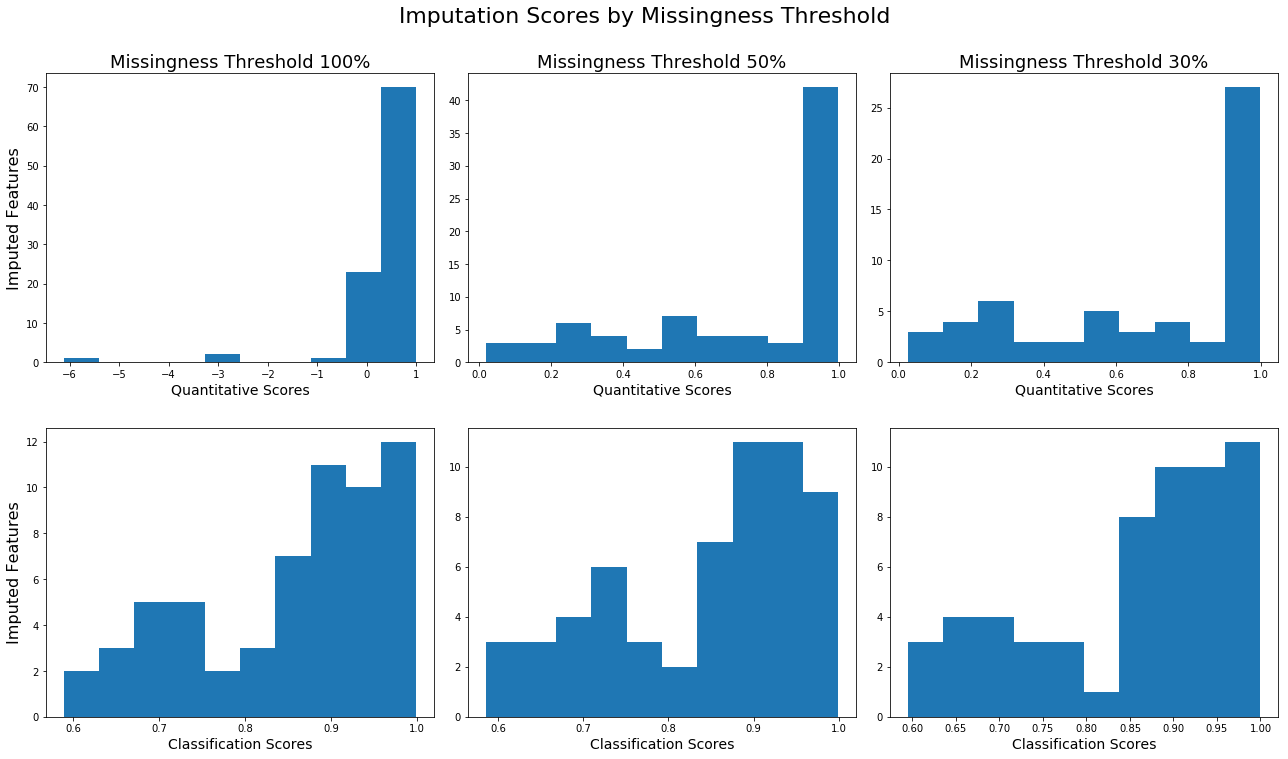

In [78]:
scores = []
thresh = [100, 50, 30]
for t in thresh:
    scores.append(pd.read_csv(f'../data/Imputed/scores_modeled_upto_{t}pct_missing.csv'))

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, ax in enumerate(axes[0].ravel()):
    reg_scores = scores[i][scores[i].Model.str.contains("StackingCVRegressor")]
    ax.set_title(f'Missingness Threshold {thresh[i]}%', size=18)
    ax.hist(reg_scores.Score)
    ax.set_xlabel('Quantitative Scores\n', size=14)
    if (i == 0):
        ax.set_ylabel('Imputed Features', size=16)

for i, ax in enumerate(axes[1].ravel()):
    reg_scores = scores[i][scores[i].Model.str.contains("StackingCVClassifier")]
    ax.hist(reg_scores.Score)
    ax.set_xlabel('Classification Scores', size=14)
    if (i == 0):
        ax.set_ylabel('Imputed Features', size=16)


fig.tight_layout()
fig.suptitle("Imputation Scores by Missingness Threshold", size=22, y=1.05)
plt.show()

Looking at our scores, we see that the imputation accuracy ranges from $.6$ to $1$ for categorical features. For quantitative features, we have a few features with a negative $R^2$, although most are in the $.6$ to $1$ range.


To understand if our stacking/cv model-based imputation approach was worth the effort, we created mean/mode imputed design matrices at $.5$ and $.3$ thresholds of missingness for comparison.

In [170]:
thresholds = [.5, .3]
for missing_thresh in thresholds:

    # Read in data and identify categorical and non-categorical features
    pat_comb, categoricals, non_cat = get_combined_data(missing_thresh)

    # Scale all columns that are non-categorical
    pat_comb = utils.scale_cols(data=pat_comb, cols=non_cat, scaler=MinMaxScaler())

    non_cat_cols = pat_comb[non_cat]
    non_cat_cols = non_cat_cols.fillna(non_cat_cols.mean())


    cat_cols = pat_comb[categoricals]
    cat_cols = cat_cols.fillna(cat_cols.mode().iloc[0])

    pat_comb.update(non_cat_cols)
    pat_comb.update(cat_cols)

    mean_mode_file = f'../data/Imputed/data_mean_upto_{int(missing_thresh * 100)}pct_missing.csv'
    pat_comb.to_csv(mean_mode_file)

Dropped columns due to missingness at threshold 0.5:
 {'DADAD', 'UAT3', 'DXNORM', 'DXMPTR5', 'DXMPTR2', 'DXMPTR4', 'DXMPTR1', 'HMT96', 'MH14BALCH', 'BAT324', 'HMT93', 'MH15BDRUG', 'MH14AALCH', 'UAT2', 'AXT117', 'MH14CALCH', 'HMT95', 'CMT2', 'HMT98', 'HMT20', 'DXMPTR3', 'DXNODEP', 'CMT3', 'HMT70', 'MH16CSMOK', 'DIGITSCOR', 'HMT69', 'MH16ASMOK', 'HMT21', 'MH15ADRUG', 'MH16BSMOK'}

Dropped columns due to missingness at threshold 0.3:
 {'EcogPtPlan', 'DADAD', 'UAT3', 'DXNORM', 'DXMPTR5', 'EcogPtMem', 'DXMPTR2', 'DXMPTR4', 'PTAU', 'DXDEP', 'DXMPTR1', 'ABETA', 'FDG', 'HMT96', 'MH14BALCH', 'BAT324', 'HMT93', 'EcogPtOrgan', 'MH15BDRUG', 'DXPARK', 'MH14AALCH', 'TAU', 'EcogPtTotal', 'UAT2', 'AXT117', 'MH14CALCH', 'EcogSPPlan', 'EcogPtVisspat', 'HMT95', 'CMT2', 'HMT98', 'EcogSPVisspat', 'HMT20', 'DXMPTR3', 'EcogSPTotal', 'EcogPtDivatt', 'EcogSPLang', 'EcogPtLang', 'DXNODEP', 'CMT3', 'HMT70', 'MH16CSMOK', 'DIGITSCOR', 'MOMAD', 'AV45', 'HMT69', 'MH16ASMOK', 'MOCA', 'HMT21', 'MH15ADRUG', 'EcogSPOrga

Finally, to evaluate the effectiveness of adding the additional per-patient data to the ADNI Merged dataset, we created mean/mode imputed design matrices from the ADNI Merged data at the $.5$ and $.3$ missingness threshold levels.

In [171]:
thresholds = [.5, .3]
for missing_thresh in thresholds:

    # Drop cols based on missing threshold
    bl_imputed = drop_missing_cols(baseline, missing_thresh)

    categoricals = ['PTETHCAT', 'PTGENDER', 'PTRACCAT', 'PTMARRY', 'FSVERSION', 'APOE4', 'DX_bl']
    non_cat = list(set(bl_imputed.columns) ^ set(categoricals))
    
    # Scale all columns that are non-categorical
    bl_imputed = utils.scale_cols(data=bl_imputed, cols=non_cat, scaler=MinMaxScaler())

    # Impute using mean
    non_cat_cols = bl_imputed[non_cat]
    non_cat_cols = non_cat_cols.fillna(non_cat_cols.mean())

    # Impute using mode
    cat_cols = bl_imputed[categoricals]
    cat_cols = cat_cols.fillna(cat_cols.mode().iloc[0])

    # Update baseline with imputed values
    bl_imputed.update(non_cat_cols)
    bl_imputed.update(cat_cols)

    # Save the results to disk
    mean_mode_file = f'../data/Imputed/baseline_mean_upto_{int(missing_thresh * 100)}pct_missing.csv'
    bl_imputed.to_csv(mean_mode_file)

Dropped columns due to missingness at threshold 0.5:
 {'DIGITSCOR'}

Dropped columns due to missingness at threshold 0.3:
 {'FDG', 'DIGITSCOR', 'EcogPtPlan', 'EcogSPVisspat', 'AV45', 'EcogPtOrgan', 'MOCA', 'EcogPtMem', 'EcogPtDivatt', 'EcogSPTotal', 'EcogSPLang', 'EcogSPOrgan', 'EcogPtLang', 'TAU', 'EcogPtTotal', 'PTAU', 'ABETA', 'EcogSPPlan', 'EcogPtVisspat', 'EcogSPMem', 'EcogSPDivatt'}
